## Sales Price Recommendation Project

## Based on general sales data and individual user data, automatically suggest sales prices.

* Source: OList data (sheet)[https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data?select=olist_order_items_dataset.csv]


> O que foi feito:
> * reduzi o campo para valores abaixo de 100, uma vez que a repetição de preços é maios para esse valor e abaixo.
> * Utilizei um teste com mais camadas sugerido por IA e o BatchNormalization com Dropout (estudar)
> * Coloquei os parametros de input com parcelas, dia da semana, hora e id do seller.
> * Coloquei o id do produto e a frequencia do preco para o treino, mas não como input [REMOVI]
> * Reduzi para valores abaixo de 100
> * Filtrei para repetições acima de 200 vezes
> * Apliquei o payment_type como parametro, removi o installments (porque o user vai selecionar depois) e atingi uma acuracia de 38%.
> * Apliquei o range de price_t-1 e removi os sellers que não tinham mais de uma venda. Consegui 37%.
> * Apliquei o price_t-1 como input, mas atingiu os mesmo 38%.
> * Apliquei seller_price_freque como sample_weight
> * Apliquei a cidade do vendedor como paramentro. Subiu pouco
> * Apliquei na base apenas precos que foram repetidos mais de 5 vezes pelo vendedor. 42%
> * Aumentei o Embedding do Seller para 32 por causa da qtd de sellers distintos. 
> * Proximos passos: Converter em aplicação iOS
>   
> * ### RESULTADO: 46%

In [1]:
import numpy as np 
import pandas as pd 
import uuid 
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Load dataframe

In [2]:
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_orders_items = pd.read_csv('olist_order_items_dataset.csv')
df_orders_payment = pd.read_csv('olist_order_payments_dataset.csv')
df_orders_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_sale = pd.merge(df_orders_items, df_orders_payment, on='order_id', how='inner')
df_sale = pd.merge(df_sale, df_orders, on='order_id', how='inner')
df_sale = pd.merge(df_sale, df_orders_sellers, on= 'seller_id', how='inner')

In [3]:
df_sale.shape

(117601, 21)

In [4]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117601 non-null  object 
 1   order_item_id                  117601 non-null  int64  
 2   product_id                     117601 non-null  object 
 3   seller_id                      117601 non-null  object 
 4   shipping_limit_date            117601 non-null  object 
 5   price                          117601 non-null  float64
 6   freight_value                  117601 non-null  float64
 7   payment_sequential             117601 non-null  int64  
 8   payment_type                   117601 non-null  object 
 9   payment_installments           117601 non-null  int64  
 10  payment_value                  117601 non-null  float64
 11  customer_id                    117601 non-null  object 
 12  order_status                  

# Dataframe Analisys

In [5]:
# Qtd Prices 
print(f"Total price's: {len(df_sale.price.unique())}")

Total price's: 5968


In [6]:
# total sellers 
print(f"Total sellers: {len(df_sale.seller_id.unique())}")

Total sellers: 3095


In [7]:
print('Most frequently prices')
df_sale['price'].value_counts().head(20)

Most frequently prices


price
59.90     2606
69.90     2092
49.90     2045
89.90     1623
99.90     1510
39.90     1395
29.90     1378
19.90     1279
79.90     1276
29.99     1221
49.00     1198
99.00     1009
149.90     896
109.90     826
119.90     789
99.99      753
24.90      706
35.00      700
39.99      697
49.99      690
Name: count, dtype: int64

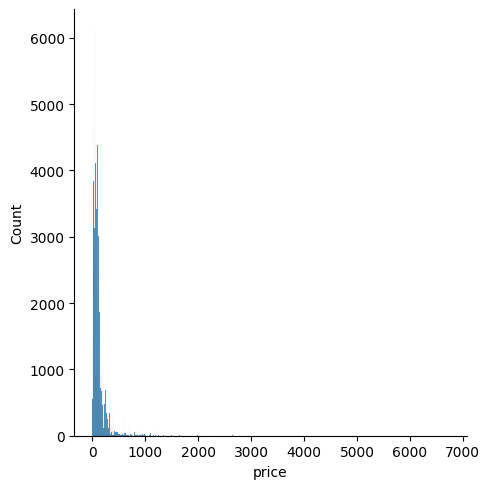

In [8]:
sns.displot(df_sale.price)

<Axes: >

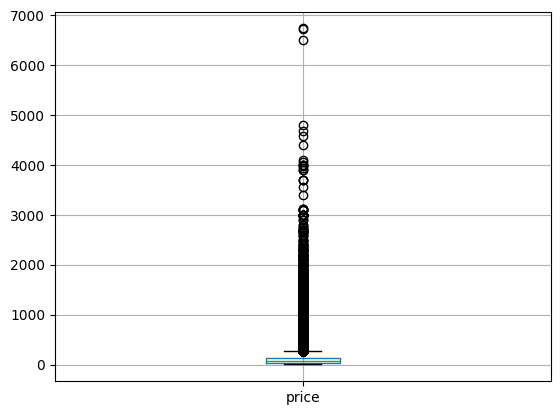

In [9]:
df_sale.boxplot(column='price')

# Feturing Engineering 

In [10]:
# timestamp , dayodweek, hour,
df_sale['timestamp'] = pd.to_datetime(df_sale['order_purchase_timestamp'])
df_sale['hour'] = df_sale['timestamp'].dt.hour
df_sale['dow'] = df_sale['timestamp'].dt.dayofweek
df_sale['day'] = df_sale['timestamp'].dt.day

In [11]:
# Cycling correction
df_sale['hour_sin'] = np.sin(2 * np.pi * df_sale['hour'] / 24)
df_sale['hour_cos'] = np.cos(2 * np.pi * df_sale['hour'] / 24)

df_sale['dayofweek_sin'] = np.sin(2 * np.pi * df_sale['dow'] / 7)
df_sale['dayofweek_cos'] = np.cos(2 * np.pi * df_sale['dow'] / 7)

In [12]:
df_sale['day_hour'] = df_sale['day'] * 24 + df_sale['hour']

In [13]:
# Label encoder
seller_encoder = LabelEncoder()
price_encoder = LabelEncoder()
df_sale['sellerID_encoded'] = seller_encoder.fit_transform(df_sale['seller_id'])
df_sale['price_class'] = price_encoder.fit_transform(df_sale['price'])

In [14]:
# Filter only for prices below 100 cause our bloxpot shows outliers in high values
df_sample = df_sale[df_sale['price'] <= 100]
print(f'Filter below 100 {df_sample.shape}')
print(f'Original {df_sale.shape}')

Filter below 100 (75676, 32)
Original (117601, 32)


In [15]:
# Filter prices with more than 200 ocurrences 

price_counts = df_sample['price'].value_counts()
print(price_counts)
print(price_counts.count())
repeated_prices = price_counts[price_counts > 200].index
df_sample = df_sample[df_sample['price'].isin(repeated_prices)]
df_sample.shape

price
59.90    2606
69.90    2092
49.90    2045
89.90    1623
99.90    1510
         ... 
11.80       1
85.51       1
41.76       1
75.35       1
43.44       1
Name: count, Length: 2528, dtype: int64
2528


(46703, 32)

<Axes: >

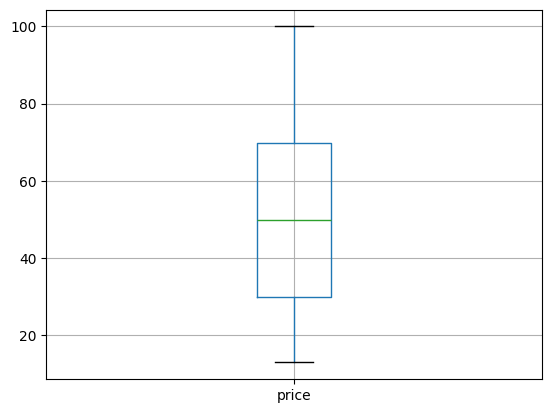

In [16]:
# Because price range is below 100, has no outliers 
df_sample.boxplot(column='price')

In [17]:
# Frequency of price in seller id
df_top = (
   df_sample.groupby('seller_id')['price']
      .value_counts()
      .reset_index(name='seller_price_freq')
)
print(df_top.head(10))


                          seller_id  price  seller_price_freq
0  001cca7ae9ae17fb1caed9dfb1094831  99.00                 85
1  001cca7ae9ae17fb1caed9dfb1094831  89.00                 29
2  001cca7ae9ae17fb1caed9dfb1094831  99.90                 14
3  001cca7ae9ae17fb1caed9dfb1094831  69.90                  8
4  001cca7ae9ae17fb1caed9dfb1094831  99.99                  7
5  001cca7ae9ae17fb1caed9dfb1094831  79.00                  1
6  001cca7ae9ae17fb1caed9dfb1094831  84.90                  1
7  002100f778ceb8431b7a1020ff7ab48f  17.90                 31
8  002100f778ceb8431b7a1020ff7ab48f  19.90                 12
9  002100f778ceb8431b7a1020ff7ab48f  12.90                  2


In [18]:
# Combine df with frequency into df
df = pd.merge(
    df_sample,
    df_top,
    on=['seller_id', 'price'],
    how='inner'
)
# remove freq = 1, looking for more than 5 ocurrences 
df = df[df['seller_price_freq'] >= 5].copy()
df.shape

(37930, 33)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37930 entries, 0 to 46702
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       37930 non-null  object        
 1   order_item_id                  37930 non-null  int64         
 2   product_id                     37930 non-null  object        
 3   seller_id                      37930 non-null  object        
 4   shipping_limit_date            37930 non-null  object        
 5   price                          37930 non-null  float64       
 6   freight_value                  37930 non-null  float64       
 7   payment_sequential             37930 non-null  int64         
 8   payment_type                   37930 non-null  object        
 9   payment_installments           37930 non-null  int64         
 10  payment_value                  37930 non-null  float64       
 11  customer_id         

In [20]:
# Payment Type
print(df.payment_type.unique())
df['payment_type_num'] = df['payment_type'].map({
    'credit_card': 0,
    'boleto': 1,
    'voucher': 2,
    'debit_card': 3
})
print(df.payment_type_num.unique())

['credit_card' 'boleto' 'voucher' 'debit_card']
[0 1 2 3]


In [21]:
# Seller City 
print(df.seller_city.nunique())
city_encoder = LabelEncoder()
df['seller_city_encoded'] = city_encoder.fit_transform(df['seller_city'])

220


In [22]:
# Payment Installments
print(df.payment_installments.nunique())
print(df.payment_installments.unique())
# I will not use this 'cause installments is picked after value choice ... 

19
[ 2  1  3  4  7  6  9  8 10  5 15 14 11 12 24  0 13 21 18]


In [23]:
# Last Price Collumn 
df_sorted = df.sort_values(['seller_id', 'timestamp'])
df_sorted['price_t-1'] = df_sorted.groupby('seller_id')['price'].shift(1)
#df['price_t-1'] = df_sorted['price_t-1'] / df_sorted['price_t-1'].max()
#df = df.dropna(subset=['price_t-1'])
#df.shape
# The idea was to use seller last price (on > 2 prices) but shows low effect in accurancy results 

In [24]:
#df['price_t-1'].unique()

In [25]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,day_hour,sellerID_encoded,price_class,seller_price_freq,payment_type_num,seller_city_encoded
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,credit_card,2,...,0.866025,-0.500000,0.974928,-0.222521,320,854,1635,11,0,218
2,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69,1,boleto,1,...,-0.707107,0.707107,0.000000,1.000000,381,1223,518,5,1,157
3,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85,1,credit_card,1,...,0.258819,-0.965926,-0.781831,0.623490,251,1371,462,68,0,184
4,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88,1,credit_card,3,...,-0.500000,0.866025,-0.974928,-0.222521,598,2481,1674,87,0,168
6,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37,1,boleto,1,...,-0.500000,0.866025,0.781831,0.623490,334,368,1389,492,1,179


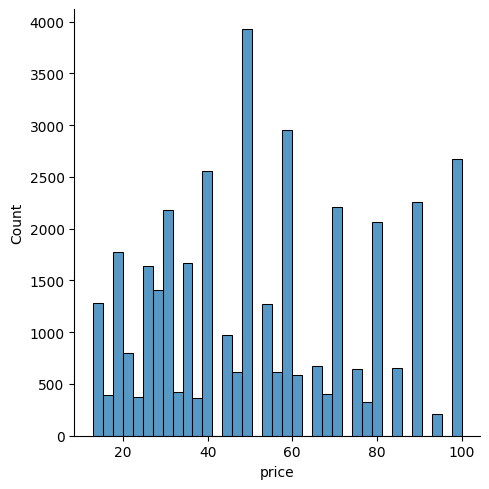

In [26]:
sns.displot(df.price)

<Axes: >

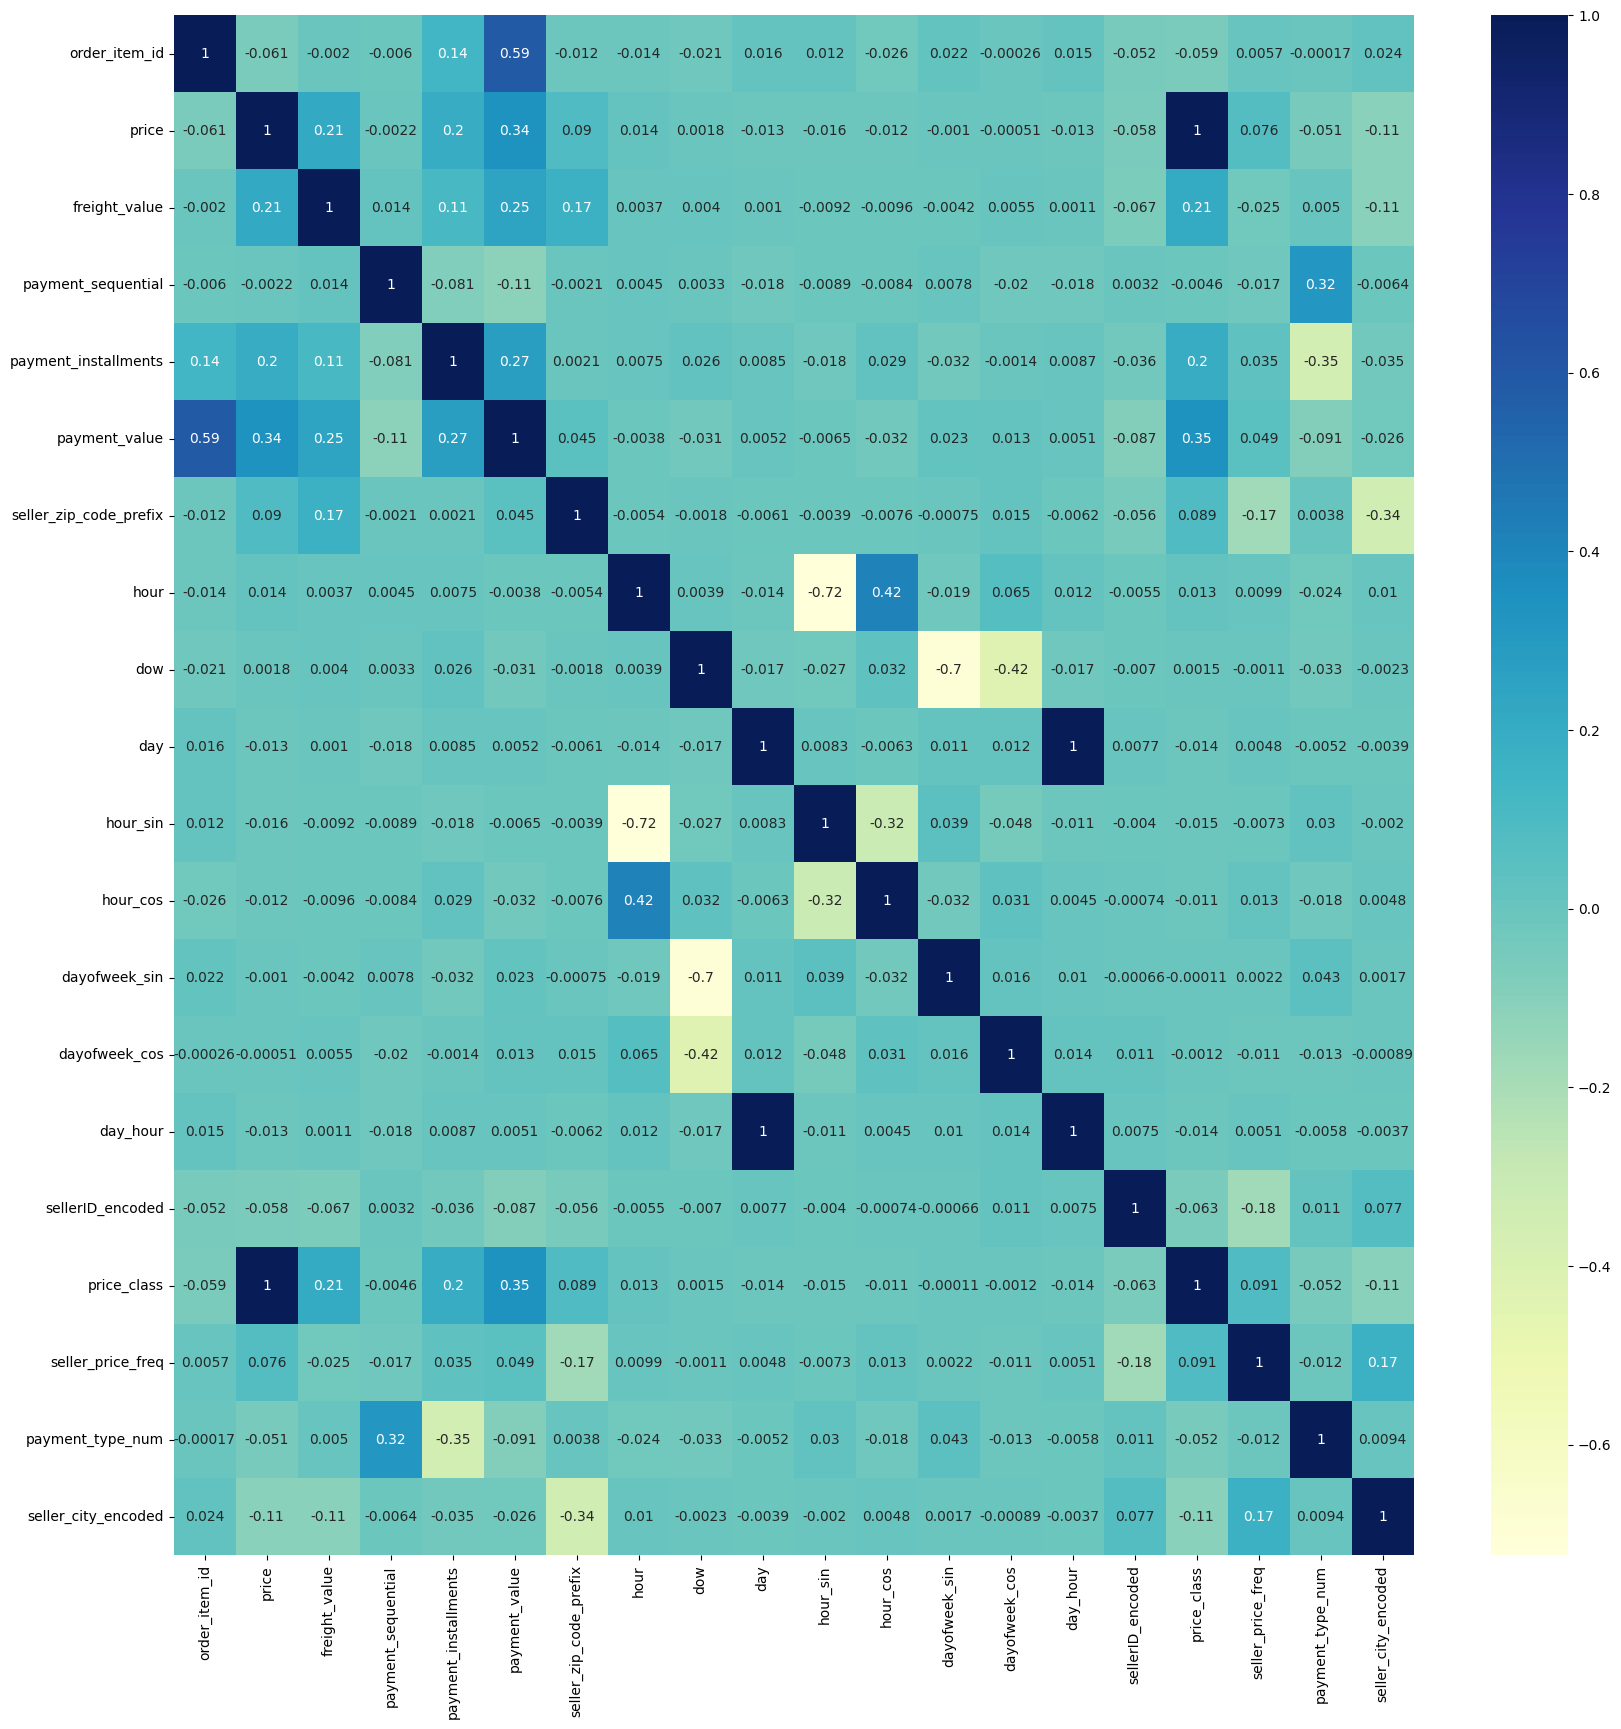

In [27]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df.corr(numeric_only=True), annot = True, cmap="YlGnBu")

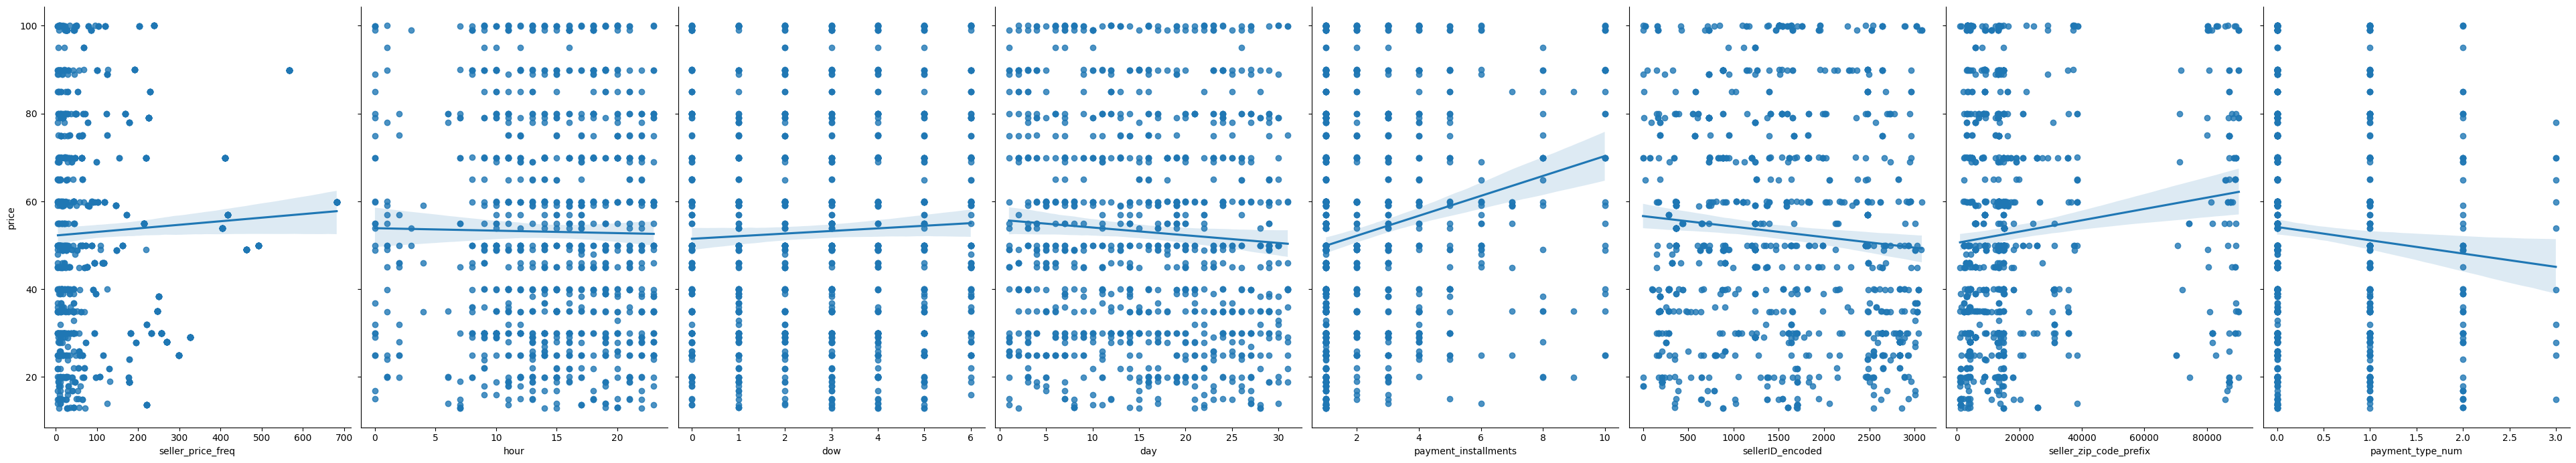

In [28]:
df2 = df.sample(n=1000, random_state=42)
sns.pairplot(df2, x_vars=['seller_price_freq', 'hour', 'dow', 'day', 'payment_installments', 
                          'sellerID_encoded', 'seller_zip_code_prefix', 'payment_type_num'], y_vars='price', height=7, 
            aspect=0.7, kind='reg')

In [29]:
df.seller_price_freq.corr(df.price)

0.07589442456812155

In [30]:
df.hour.corr(df.price)

0.013556959294402161

In [31]:
df.dow.corr(df.price)

0.0017663361083842368

In [32]:
df.day.corr(df.price)

-0.01323204308024792

In [33]:
df.day_hour.corr(df.price)

-0.01287952852375342

In [34]:
df.payment_installments.corr(df.price)

0.19539309496526586

In [35]:
df.sellerID_encoded.corr(df.price)

-0.057763492777770244

In [36]:
df.payment_type_num.corr(df.price)

-0.05089737001651544

In [37]:
df.seller_city_encoded.corr(df.price)

-0.10846363751572172

In [38]:
df.day_hour.corr(df.price)

-0.01287952852375342

In [39]:
df.dow.corr(df.price)

0.0017663361083842368

In [40]:
df.sellerID_encoded.corr(df.price)

-0.057763492777770244

In [41]:
df.price.nunique()

83

In [42]:
len(df.price)

37930

In [43]:
# Re-encode after filter
df['sellerID_encoded'] = seller_encoder.fit_transform(df['seller_id'])
df['price_class'] = price_encoder.fit_transform(df['price'])
#df['hour_class'] = price_encoder.fit_transform(df['hour'])
#df['dow_class'] = price_encoder.fit_transform(df['dayofweek'])

In [44]:
df['price_class'].value_counts(normalize=True)

price_class
58    0.060664
65    0.047509
49    0.045874
77    0.035065
81    0.033746
        ...   
7     0.003717
22    0.003427
6     0.003137
35    0.003111
60    0.003085
Name: proportion, Length: 83, dtype: float64

## Modelo de classificação

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
def train_value_classifier_model(df):
    
    features = ['hour', 'freq', 'dayofweek']
    X = df[features]
    y = df['price_class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    print(f"[Classificação] Acurácia: {acc:.2f}")
    return model

In [46]:
#df_sample_train = df.sample(n=1000, random_state=42)
#clf_model = train_value_classifier_model(df_sample_train)

# Neural network model


In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [48]:
def train_entity_embedding_model(df):
    num_sellers = df['sellerID_encoded'].nunique()
    num_classes = df['price_class'].nunique()
    num_installments = df['payment_installments'].nunique()
    num_city = df['seller_city_encoded'].nunique()
    print(f" qtd users: {num_sellers} qtd values: {num_classes}")
    # Train/test split
    X = df[['sellerID_encoded', 
            'hour', 
            'dow', 
            'payment_type_num', 
            'seller_city_encoded',
            'seller_price_freq']].astype(np.float32)
    y = df['price_class'].astype(np.float32)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=42
    )
    print(f'X: {X_train.shape}')
    print(f'y: {y_train.shape}')

    # One-hot encode targets
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)
    
    # Inputs
    seller_input = Input(shape=(1,), name='seller_input') # seeler id
    hour_input = Input(shape=(1,), name='hour_input') # Hour 
    dow_input = Input(shape=(1,), name='dayofweek') # dayofweek 
    city_input = Input(shape=(1,), name='city_input') # Installment
    payment_input = Input(shape=(1,), name='payment_input') # Payment type
    #last_price_input = Input(shape=(1,), name='last_price_input') # Last price Input
    
    # Embeddings
    seller_emb = Embedding(input_dim=num_sellers + 1, output_dim=32)(seller_input)
    hour_emb = Embedding(input_dim=24 + 1, output_dim=4)(hour_input)
    dow_emb = Embedding(input_dim=7 + 1, output_dim=4)(dow_input)
    city_emb = Embedding(input_dim=num_city + 1, output_dim=4)(city_input)
    payment_emb = Embedding(input_dim=4 + 1, output_dim=3)(payment_input)

    # Concatenate
    
    seller_emb_flat = Flatten()(seller_emb)
    hour_emb_flat = Flatten()(hour_emb)
    dow_emb_flat = Flatten()(dow_emb)
    city_emb_flat = Flatten()(city_emb)
    payment_emb_flat = Flatten()(payment_emb)
    
    x = Concatenate()([seller_emb_flat, hour_emb_flat, dow_emb_flat, city_emb_flat, payment_emb_flat]) 
    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[seller_input, hour_input, dow_input, city_input, payment_input], outputs=output)
    opt = Adam(learning_rate=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    # Fit
    model.fit(
        [X_train['sellerID_encoded'], 
         X_train['hour'], 
         X_train['dow'], 
         X_train['seller_city_encoded'],
         X_train['payment_type_num']],
        y_train_cat,
        validation_data=(
            [X_test['sellerID_encoded'],  
             X_test['hour'], 
             X_test['dow'], 
             X_test['seller_city_encoded'],
             X_test['payment_type_num']],
            y_test_cat
        ),
        sample_weight=X_train['seller_price_freq'],
        epochs=20,
        batch_size=128,
        verbose=1
    )

    return model, X_test, y_test

In [49]:
# Training a Sample
df_sample_train = df.sample(n=30000, random_state=42)
df_sample_train['sellerID_encoded'] = seller_encoder.fit_transform(df_sample_train['seller_id'])
df_sample_train['price_class'] = price_encoder.fit_transform(df_sample_train['price'])
#model, X_test, y_test = train_entity_embedding_model(df_sample_train)
model, X_test, y_test = train_entity_embedding_model(df)

 qtd users: 688 qtd values: 83
X: (28447, 6)
y: (28447,)


2025-07-23 19:22:22.577764: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-23 19:22:22.577802: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-23 19:22:22.577805: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-23 19:22:22.577823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-23 19:22:22.577836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seller_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hour_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dayofweek           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ city_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │     22,048 │ seller_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 4)      │        100 │ hour_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 4)      │         32 │ dayofweek[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 4)      │        884 │ city_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 3)      │         15 │ payment_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 3)         │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 47)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      3,072 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]     

 Total params: 30,970 (120.98 KB)

 Trainable params: 30,970 (120.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-07-23 19:22:23.094647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0565 - loss: 435.1786 - val_accuracy: 0.1670 - val_loss: 3.7316
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2065 - loss: 215.2696 - val_accuracy: 0.2921 - val_loss: 3.1612
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3137 - loss: 164.8691 - val_accuracy: 0.3574 - val_loss: 2.8386
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3688 - loss: 146.2704 - val_accuracy: 0.3828 - val_loss: 2.6711
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3995 - loss: 136.7326 - val_accuracy: 0.4031 - val_loss: 2.5788
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4150 - loss: 132.1049 - val_accuracy: 0.4144 - val_loss: 2.5110
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4318 - loss: 129.7539 - val_accuracy: 0.4224 - val_loss: 2.4474
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4415 - loss: 129.3830 - val

## Accurancy Validation

In [50]:
# Main Seller will used for validations 
mainSeller = '001cca7ae9ae17fb1caed9dfb1094831'
df_seller = df[df['seller_id'] == mainSeller].copy()
print(df_seller['price'].unique())
df_seller[['sellerID_encoded','payment_type','seller_city', 'payment_type_num', 'seller_city_encoded']].head()

[99.   89.   99.99 69.9  99.9 ]


,sellerID_encoded,payment_type,seller_city,payment_type_num,seller_city_encoded
65,0,credit_card,cariacica,0,38
648,0,credit_card,cariacica,0,38
1211,0,credit_card,cariacica,0,38
1342,0,boleto,cariacica,1,38
1590,0,credit_card,cariacica,0,38


In [51]:
# Other Seller will used for validations 
otherSeller = '002100f778ceb8431b7a1020ff7ab48f'
df_seller = df[df['seller_id'] == otherSeller].copy()
print(df_seller['price'].unique())
df_seller[['sellerID_encoded','payment_type','seller_city', 'payment_type_num', 'seller_city_encoded']].head()

[19.9 17.9]


,sellerID_encoded,payment_type,seller_city,payment_type_num,seller_city_encoded
783,1,boleto,franca,1,66
784,1,boleto,franca,1,66
2210,1,boleto,franca,1,66
3440,1,credit_card,franca,0,66
3943,1,boleto,franca,1,66


### RMSE

In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
y_pred_proba = model.predict([X_test['sellerID_encoded'],
                              X_test['hour'],
                              X_test['dow'],
                              X_test['seller_city_encoded'],
                              X_test['payment_type_num']])

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [54]:
y_pred_classes = np.argmax(y_pred_proba, axis=1)

In [55]:
y_pred_prices = price_encoder.inverse_transform(y_pred_classes.astype(int))
y_true_prices = price_encoder.inverse_transform(y_test.astype(int))

In [56]:
rmse = np.sqrt(mean_squared_error(y_true_prices, y_pred_prices))
print(f"RMSE: {rmse:.2f}")

RMSE: 19.53


In [57]:
def predict_top_values_nn(model, 
                          seller_encoder, 
                          price_encoder, 
                          city_encoder,
                          seller_id, 
                          hour, 
                          dow, 
                          city, 
                          payment, 
                          top_n=3):
    try:
        seller_id_encoded = seller_encoder.transform([seller_id])[0]
        city_encoded = city_encoder.transform([city])[0]
    except ValueError:
        seller_id_encoded = -1  # ou 0, dependendo do caso

    input_data = [
        np.array([seller_id_encoded]),
        np.array([hour]),
        np.array([dow]),
        np.array([city_encoded]),
        np.array([payment])
    ]

    proba = model.predict(input_data, verbose=0)[0]
    #print(proba)
    top_indices = proba.argsort()[-top_n:][::-1]
    top_values = price_encoder.inverse_transform(top_indices)
    top_scores = proba[top_indices]

    return list(zip(top_values, top_scores))

In [58]:
# Checking Prediction - MainUser
some_user = mainSeller
top_preds = predict_top_values_nn(model, seller_encoder, price_encoder, city_encoder, 
                                  seller_id=some_user, hour=11, dow=3, city='cariacica', payment=0)

print("Top 3 prices NN with embedding:")
for val, prob in top_preds:
    print(f"R$ {val} com confiança de {prob:.2f}")


Top 3 prices NN with embedding:
R$ 99.0 com confiança de 0.92
R$ 89.0 com confiança de 0.03
R$ 79.0 com confiança de 0.01


In [59]:
# Checking Prediction - OtherUser
some_user = otherSeller
top_preds = predict_top_values_nn(model, seller_encoder, price_encoder, city_encoder, 
                                  seller_id=some_user, hour=11, dow=3, city='franca', payment=1)

print("Top 3 prices NN with embedding:")
for val, prob in top_preds:
    print(f"R$ {val} com confiança de {prob:.2f}")


Top 3 prices NN with embedding:
R$ 17.9 com confiança de 0.70
R$ 19.9 com confiança de 0.09
R$ 24.9 com confiança de 0.06


In [60]:
def avaliar_usuario(model, df, seller_id):
    # Seller filter
    df_seller = df[df['seller_id'] == seller_id].copy()

    # df_user = df_user.sort_values('timestamp')
   
    # # Transformar os valores
    # df_user['sellerID_encoded'] = seller_encoder.transform(df_user['selle'])
    # df_user['price_class'] = price_encoder.transform(df_user['value'])
    
    # Prediction
    preds_proba = model.predict([
        df_seller['sellerID_encoded'].values,
        df_seller['hour'].values,
        df_seller['dow'].values,
        df_seller['seller_city_encoded'].values,
        df_seller['payment_type_num'].values
    ], verbose=1)

    preds_class = np.argmax(preds_proba, axis=1)
    acc = accuracy_score(df_seller['price_class'], preds_class)

    print(f"Acurácia para o sellerID '{seller_id}': {acc:.2%}")
    #print(preds_proba)
    return preds_class, df_seller

In [61]:
def plotar_resultado_usuario(preds_class, df_seller, price_encoder):
    
    # Converter classes preditas para valores reais
    price_predicts = price_encoder.inverse_transform(preds_class)
    price_source = df_seller['price'].values
    #print(price_predicts)
    plt.figure(figsize=(10, 5))
    plt.plot(price_source, label='Valor real', marker='o')
    plt.plot(price_predicts, label='Valor predito', marker='x')
    plt.title(f"Comparação: Real vs Predito (userID={df_seller['seller_id'].iloc[0]})")
    plt.xlabel("Transações")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/stepWARNING:tensorflow:5 out of the last 304 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3221a5120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Acurácia para o sellerID '001cca7ae9ae17fb1caed9dfb1094831': 59.44%


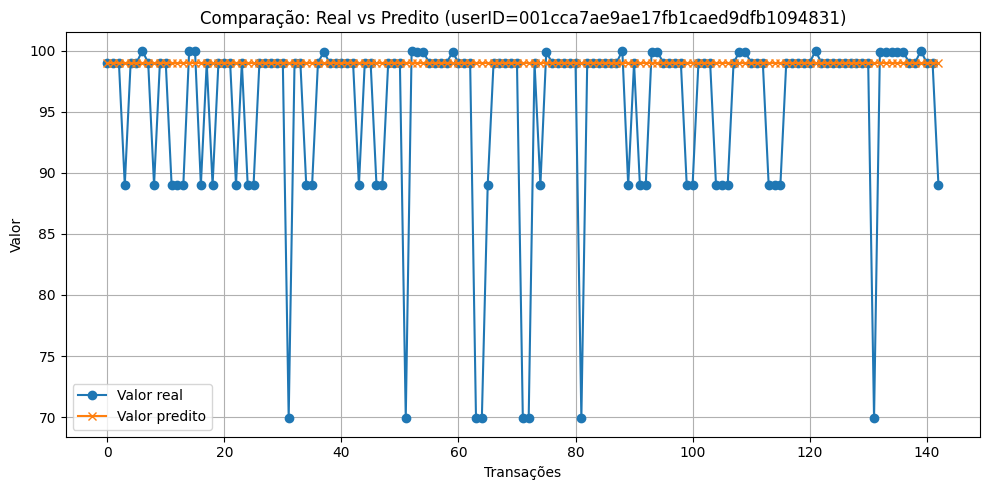

In [62]:
seller_id = mainSeller
preds_class, df_seller = avaliar_usuario(model, df, seller_id)
plotar_resultado_usuario(preds_class, df_seller, price_encoder)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Acurácia para o sellerID '002100f778ceb8431b7a1020ff7ab48f': 72.09%


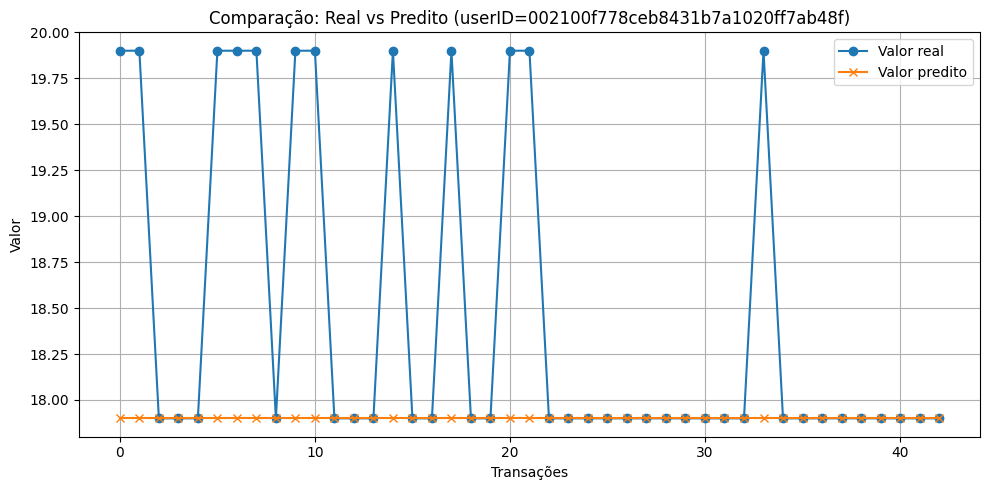

In [63]:
seller_id = otherSeller
preds_class, df_seller = avaliar_usuario(model, df, seller_id)
plotar_resultado_usuario(preds_class, df_seller, price_encoder)

## Results for mainSeller / otherSeller
> ### mainSeller: R$ 99.0 with trust 0.90 - 59% Accurancy

> ### otherSeller: R$ 17.9 with trust 0.80 - 72% Accurancy

## Save model an check prediction

In [64]:
## Salvando o Modelo 
model.save("modelo_recomendacao.h5")

In [65]:
from tensorflow import keras
# Carrega o modelo .keras
model_saved = keras.models.load_model("modelo_recomendacao.h5")
some_user = mainSeller
top_preds = predict_top_values_nn(model, seller_encoder, price_encoder, city_encoder, 
                                  seller_id=some_user, hour=11, dow=3, city='franca', payment=1)

print("Top 3 valores previstos via NN com embedding:")
for val, prob in top_preds:
    print(f"R$ {val} com confiança de {prob:.2f}")


Top 3 valores previstos via NN com embedding:
R$ 99.0 com confiança de 0.84
R$ 89.0 com confiança de 0.06
R$ 79.0 com confiança de 0.03


## Exporta para TensorFlow Lite
> We will bring the model to iOS mobile application 

In [66]:
import tensorflow as tf

# Salva no formato SavedModel (em uma pasta)
model.export("model_tf")

converter = tf.lite.TFLiteConverter.from_saved_model("model_tf")
tflite_model = converter.convert()

with open("modelo_recomendacao.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: model_tf/assets


INFO:tensorflow:Assets written to: model_tf/assets


Saved artifact at 'model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 1), dtype=tf.float32, name='seller_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='hour_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='dayofweek'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='city_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='payment_input')]
Output Type:
  TensorSpec(shape=(None, 83), dtype=tf.float32, name=None)
Captures:
  13345872480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13345873184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13345873888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13345873536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13345872304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13345875472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13345876352: TensorSpec(shape=(), dtype=tf.resource, name=None)

W0000 00:00:1753309442.705667 2679291 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1753309442.705861 2679291 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-07-23 19:24:02.706342: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model_tf
2025-07-23 19:24:02.706737: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-07-23 19:24:02.706742: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model_tf
2025-07-23 19:24:02.712812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-07-23 19:24:02.713324: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-07-23 19:24:02.736255: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: model_tf
2025-07-23 19:24:02.742903: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load fo

# Exportar os Labels Encodeds

In [67]:
import json

with open("seller_classes.json", "w") as f:
    json.dump(seller_encoder.classes_.tolist(), f)

with open("price_classes.json", "w") as f:
    json.dump(price_encoder.classes_.tolist(), f)

with open("seller_city_classes.json", "w") as f:
    json.dump(city_encoder.classes_.tolist(), f)
    

In [68]:
interpreter = tf.lite.Interpreter(model_path="modelo_recomendacao.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()

for i, input in enumerate(input_details):
    print(f"Input {i}: name={input['name']}, shape={input['shape']}, dtype={input['dtype']}")

Input 0: name=serving_default_payment_input:0, shape=[1 1], dtype=<class 'numpy.float32'>
Input 1: name=serving_default_hour_input:0, shape=[1 1], dtype=<class 'numpy.float32'>
Input 2: name=serving_default_seller_input:0, shape=[1 1], dtype=<class 'numpy.float32'>
Input 3: name=serving_default_dayofweek:0, shape=[1 1], dtype=<class 'numpy.float32'>
Input 4: name=serving_default_city_input:0, shape=[1 1], dtype=<class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [69]:
# Export Seller table 
df_seller_export = df[['seller_id', 'seller_city', 'payment_type', 'hour', 'dow', 'price']]
df_seller_export.to_json("seller_table.json", orient="records", indent=2)
df_seller_export.head()

,seller_id,seller_city,payment_type,hour,dow,price
0,48436dade18ac8b2bce089ec2a041202,volta redonda,credit_card,8,2,58.90
2,6426d21aca402a131fc0a5d0960a3c90,ribeirao preto,boleto,21,0,21.90
3,7040e82f899a04d1b434b795a43b4617,sao paulo,credit_card,11,6,19.90
4,cc419e0650a3c5ba77189a1882b7556a,santo andre,credit_card,22,5,59.99
6,1f50f920176fa81dab994f9023523100,sao jose do rio preto,boleto,22,1,49.90


# Tensor FLow Lite Validation

In [70]:
interpreter = tf.lite.Interpreter(model_path="modelo_recomendacao.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Input exato que você está testando no iOS
hour = np.array([[11]], dtype=np.float32)
dow = np.array([[3]], dtype=np.float32)
city = np.array([[38]], dtype=np.float32)
payment = np.array([[0]], dtype=np.float32)
sellerID_encoded = 0
seller = np.array([[sellerID_encoded]], dtype=np.float32)

#seller_id=some_user, hour=11, dow=3, city='franca', payment=1
interpreter.set_tensor(input_details[0]['index'], payment)
interpreter.set_tensor(input_details[1]['index'], hour)
interpreter.set_tensor(input_details[2]['index'], seller)
interpreter.set_tensor(input_details[3]['index'], dow)
interpreter.set_tensor(input_details[4]['index'], city)

interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
proba = output.flatten()
top_n = 3
top_indices = proba.argsort()[-top_n:][::-1]
top_values = price_encoder.inverse_transform(top_indices)
top_scores = proba[top_indices]
for val, prob in zip(top_values, top_scores):
    print(f"R$ {val} com confiança de {prob:.2f}")

R$ 99.0 com confiança de 0.89
R$ 89.0 com confiança de 0.03
R$ 79.0 com confiança de 0.02


In [71]:
# Resultado iOS 
# User: Optional("88ec2d7a13df4ae89460c7024c79ce1b")
# prob: [0.051348798, 0.089609094, 0.05192513, 0.08692917, 0.08880847, 0.036730684, 
# 0.2526983, 0.15639733, 0.046499643, 0.048701532, 0.03751736, 0.025469735, 
# 0.027364714]